# Equivalent water thickness/canopy water content from AVIRIS-NG data

This tutorial shows how to calculate equivalent water thickness or canopy water content (CWC) from [BioSCape AVIRIS-NG L3 Reflectance Mosaics](https://daac.ornl.gov/cgi-bin/dataset_lister.pl?p=47) data. Variations in CWC can indicate drought stress and wildfire risk.

We will apply a simple fitting of spectral absorption features of liquid water and use scripts available from the [ISOFIT package](https://github.com/isofit/isofit/tree/main).

## Canopy Water Content (CWC)

The CWS is derived from surface reflectance by applying a well-validated algorithm based on a physical model (Beer-Lambert model) (Green et al. 2006; Bohn et al. 2020). Derived surface reflectance spectra were particularly smooth in water absorption bands and include estimates of per-band posterior uncertainties (Thompson et al. 2018). Of note, this model does not account for multiple scattering effects within the canopy and may result in an overestimation of retrieved CWC (Bohn et al. 2020).

## References
- Bohn, N., L. Guanter, T. Kuester, R. Preusker, and K. Segl. 2020. Coupled retrieval of the three phases of water from spaceborne imaging spectroscopy measurements. Remote Sensing of Environment 242:111708. https://doi.org/10.1016/j.rse.2020.111708
- Green, R.O., T.H. Painter, D.A. Roberts, and J. Dozier. 2006. Measuring the expressed abundance of the three phases of water with an imaging spectrometer over melting snow. Water Resources Research 42:W10402. https://doi.org/10.1029/2005WR004509
- Thompson, D.R., V. Natraj, R.O. Green, M.C. Helmlinger, B.-C. Gao, and M.L. Eastwood. 2018. Optimal estimation for imaging spectrometer atmospheric correction. Remote Sensing of Environment 216:355–373. https://doi.org/10.1016/j.rse.2018.07.003

## Datasets
-  Brodrick, P. G., Chlus, A. M., Eckert, R., Chapman, J. W., Eastwood, M., Geier, S., Helmlinger, M., Lundeen, S. R., Olson-Duvall, W., Pavlick, R., Rios, L. M., Thompson, D. R., & Green, R. O. (2025). BioSCape: AVIRIS-NG L3 Resampled Reflectance Mosaics, V2. ORNL Distributed Active Archive Center. https://doi.org/10.3334/ORNLDAAC/2427

## Import modules
Let's first import the required Python modules.

In [1]:
import requests
import rasterio
import rioxarray
import boto3
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from os import path
from scipy.optimize import least_squares
import earthaccess
import xarray as xr
import hvplot.xarray
import holoviews as hv

## Earthdata Authentication

In [2]:
# ask for EDL credentials and persist them in a .netrc file
auth = earthaccess.login(strategy="interactive", persist=True)

## Retrieve AVIRIS-NG Spectra

### AVIRIS-NG File
We will use the file `AVIRIS-NG_BIOSCAPE_V02_L3_33_55` for this tutorial. Let's retrieve it using the `earthaccess` python module. 

In [3]:
# search granules
granules = earthaccess.search_data(
    doi='10.3334/ORNLDAAC/2427', # Bioscape AVIRIS-NG L2
    granule_name = "*AVIRIS-NG_BIOSCAPE_V02_L3_33_55*", # *ang20231110t070302_007*
)

Let's print the first granule.

In [4]:
granules[0]

Collection: {'ShortName': 'BioSCape_ANG_V02_L3_RFL_Mosaic_2427', 'Version': '2'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 23.2546, 'Latitude': -34.0107}, {'Longitude': 23.2563, 'Latitude': -33.9213}, {'Longitude': 23.1473, 'Latitude': -33.9199}, {'Longitude': 23.1456, 'Latitude': -34.0093}, {'Longitude': 23.2546, 'Latitude': -34.0107}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-10-22T00:00:00Z', 'EndingDateTime': '2023-11-26T23:59:59Z'}}
Size(MB): 7418.675982475281
Data: ['https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_33_55_QL.tif', 'https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_33_55_UNC.nc', 'https://data.ornldaac.earthdata.nasa.gov/protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_33_55_RFL.nc']

We will use `earthaccess` to retrieve a list of file-like objects on AWS S3 buckets.

In [5]:
# earthaccess open
fh = earthaccess.open(granules)
fh

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

[<File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_33_55_QL.tif>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_33_55_UNC.nc>,
 <File-like object S3FileSystem, ornl-cumulus-prod-protected/bioscape/BioSCape_ANG_V02_L3_RFL_Mosaic/data/AVIRIS-NG_BIOSCAPE_V02_L3_33_55_RFL.nc>]

Let's open the reflectance file as xarray datatree.

In [6]:
for f in fh:
    if f.path.endswith("_RFL.nc"):
        # plot a single file netcdf
        ds = xr.open_datatree(f, engine='h5netcdf', chunks={})
#print
ds

<xarray.DataTree>
Group: /
│   Dimensions:              (easting: 2000, northing: 2000)
│   Coordinates:
│     * easting              (easting) float64 16kB 1.23e+06 1.23e+06 ... 1.24e+06
│     * northing             (northing) float64 16kB 8.6e+05 8.6e+05 ... 8.5e+05
│   Data variables:
│       transverse_mercator  |S1 1B ...
│   Attributes: (12/22)
│       Conventions:                       CF-1.6
│       date_created:                      2025-04-23T20:55:40Z
│       summary:                           Mosaic of AVIRIS-NG L2A Reflectance da...
│       keywords:                          Imaging Spectroscopy, AVIRIS, AVIRIS-NG
│       sensor:                            Airborne Visible / Infrared Imaging Sp...
│       instrument:                        AVIRIS-NG
│       ...                                ...
│       ncei_template_version:             NCEI_NetCDF_Grid_Template_v2.0
│       title:                             AVIRIS-NG L3 Mosaiced Surface Reflecta...
│       processing_level:                  L3
│       time_coverage_start:               2023-10-22T00:00:00Z
│       time_coverage_end:                 2024-11-26T23:59:59Z
│       product_version:                   002
├── Group: /reflectance
│       Dimensions:      (wavelength: 425, northing: 2000, easting: 2000)
│       Coordinates:
│         * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
│       Data variables:
│           fwhm         (wavelength) float32 2kB dask.array<chunksize=(425,), meta=np.ndarray>
│           reflectance  (wavelength, northing, easting) float32 7GB dask.array<chunksize=(10, 256, 256), meta=np.ndarray>
├── Group: /obs
│       Dimensions:             (northing: 2000, easting: 2000)
│       Data variables:
│           path_length         (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
│           to_sensor_azimuth   (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
│           to_sensor_zenith    (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
│           to_sun_azimuth      (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
│           to_sun_zenith       (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
│           solar_phase         (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
│           slope               (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
│           aspect              (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
│           cosine_i            (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
│           utc_time            (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
│           earth_sun_distance  (northing, easting) float32 16MB dask.array<chunksize=(256, 256), meta=np.ndarray>
└── Group: /scene_info
        Dimensions:      (northing: 2000, easting: 2000, scene_ids: 3647)
        Dimensions without coordinates: scene_ids
        Data variables:
            scene_id     (northing, easting) uint16 8MB dask.array<chunksize=(256, 256), meta=np.ndarray>
            scene_names  (scene_ids) <U22 321kB dask.array<chunksize=(3647,), meta=np.ndarray>

We will now convert the reflectance to xarray dataset. 

In [7]:
rfl_netcdf = ds.reflectance.to_dataset()
rfl_netcdf

<xarray.Dataset> Size: 7GB
Dimensions:      (wavelength: 425, northing: 2000, easting: 2000)
Coordinates:
  * easting      (easting) float64 16kB 1.23e+06 1.23e+06 ... 1.24e+06 1.24e+06
  * northing     (northing) float64 16kB 8.6e+05 8.6e+05 ... 8.5e+05 8.5e+05
  * wavelength   (wavelength) float32 2kB 377.2 382.2 ... 2.496e+03 2.501e+03
Data variables:
    fwhm         (wavelength) float32 2kB dask.array<chunksize=(425,), meta=np.ndarray>
    reflectance  (wavelength, northing, easting) float32 7GB dask.array<chunksize=(10, 256, 256), meta=np.ndarray>

We will plot the reflectance using hvplot.

In [8]:
h = rfl_netcdf.reflectance.sel({'wavelength': 660},method='nearest').hvplot('easting', 'northing',
                                                      rasterize=True, data_aspect=1,
                                                      cmap='magma',frame_width=400,clim=(0,0.03))
h

:DynamicMap   []
   :Image   [easting,northing]   (Mosaiced Hemispherical Directional Reflectance Factor)

Let's retrieve a spectra from the AVIRIS-NG file and plot.

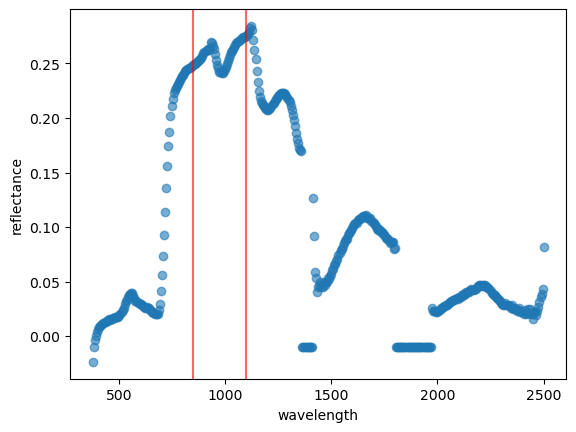

In [9]:
rfl_meas = rfl_netcdf.reflectance.isel(northing=1500, easting=1500).values
wl = rfl_netcdf.wavelength.values
plt.axvline(x = 850, color = 'r', alpha=0.6)
plt.axvline(x = 1100, color = 'r', alpha=0.6)
plt.scatter(wl, rfl_meas, alpha=0.6)
plt.xlabel("wavelength")
plt.ylabel("reflectance")
plt.show()

## Beer-lambert Law
Let's define a function that returns the vector of residuals between measured and modeled surface reflectance. The surface reflectance optimizes for the path length of surface liquid water based on the Beer-Lambert attenuation law.

In [10]:
def beer_lambert_model(x, y, wl, alpha_lw):
    """
    Args:
        x:        state vector (liquid water path length, intercept, slope)
        y:        measurement (surface reflectance spectrum)
        wl:       instrument wavelengths
        alpha_lw: wavelength dependent absorption coefficients of liquid water

    Returns:
        resid: residual between modeled and measured surface reflectance
    """

    attenuation = np.exp(-x[0] * 1e7 * alpha_lw)
    rho = (x[1] + x[2] * wl) * attenuation
    resid = rho - y

    return resid

## Refractive indices of different water phases
There is a file in the `data` folder called `k_liquid_water_ice.csv`, which provides refractive indices of different water phases. This is the imaginary part of the liquid water refractive index. Let's open that file and display the first few lines.

In [11]:
k_wi = pd.read_csv("images/k_liquid_water_ice.csv")
k_wi.head()

wvl_1      T = 22°C  wvl_2  T = -8°C  wvl_3  T = -25°C  wvl_4  \
0  666.7  2.470000e-08    NaN       NaN    NaN        NaN  660.0   
1  667.6  2.480000e-08    NaN       NaN    NaN        NaN  670.0   
2  668.4  2.480000e-08    NaN       NaN    NaN        NaN  680.0   
3  669.3  2.520000e-08    NaN       NaN    NaN        NaN  690.0   
4  670.2  2.530000e-08    NaN       NaN    NaN        NaN  700.0   

       T = -7°C  wvl_5  T = 25°C (H)  wvl_6      T = 20°C      wvl_7  \
0  1.660000e-08  650.0  1.640000e-08  650.0  1.870000e-08  650.12971   
1  1.890000e-08  675.0  2.230000e-08  651.0  1.890000e-08  654.63616   
2  2.090000e-08  700.0  3.350000e-08  652.0  1.910000e-08  660.69347   
3  2.400000e-08  725.0  9.150000e-08  653.0  1.940000e-08  665.27314   
4  2.900000e-08  750.0  1.560000e-07  654.0  1.970000e-08  669.88461   

   T = 25°C (S)  Index  
0  1.674130e-08      0  
1  1.777420e-08      1  
2  1.939950e-08      2  
3  2.031380e-08      3  
4  2.097930e-08      4

The table above provides the imaginary part of the liquid water refractive index for seven temperatures. Let's plot these values.

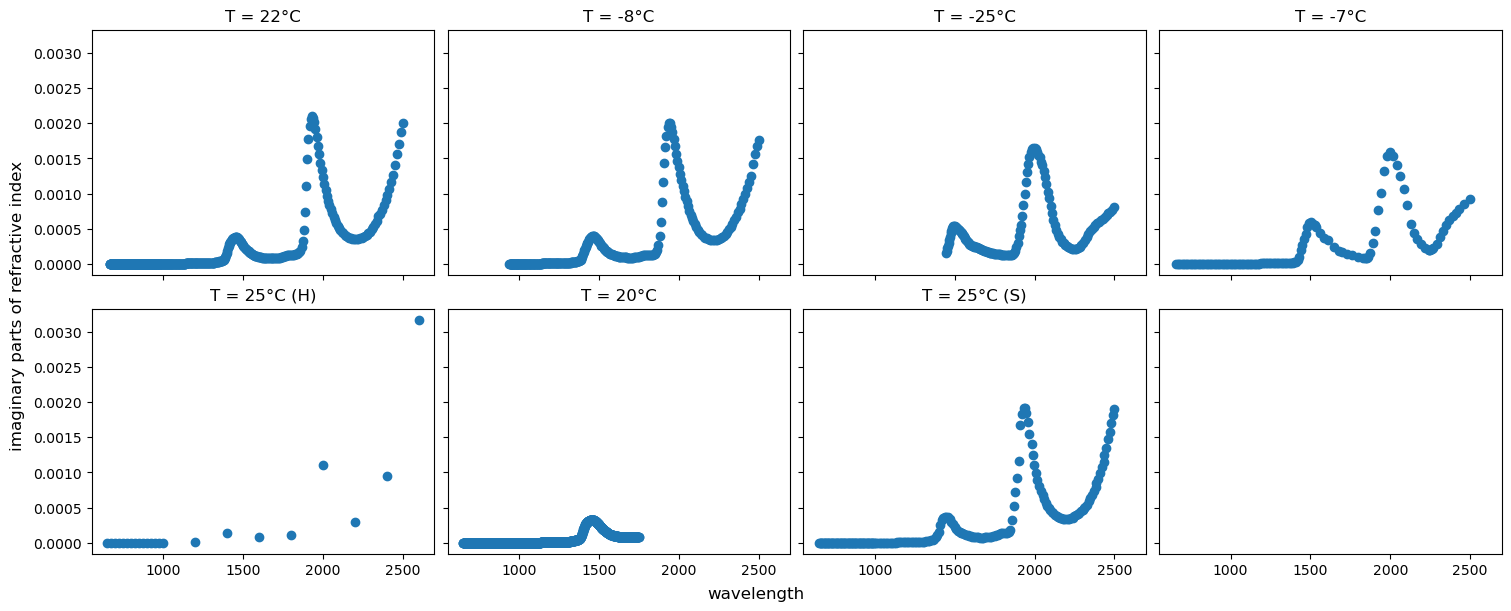

In [12]:
fig, axs = plt.subplots(2,4, figsize=(15, 6),  sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()
col_n = 0
for i in range(0, 7):
    x = k_wi.iloc[:, col_n+i]
    y = k_wi.iloc[:, col_n+i+1]
    axs[i].scatter(x, y)
    axs[i].set_title(y.name)
    col_n+=1
fig.supylabel('imaginary parts of refractive index')
fig.supxlabel('wavelength')
plt.show()

We will use `wvl_6` as the wavelength column and `T = 20°C` as the k column or imaginary parts of refractive index, when doing the inversion below.

## Inversion
Given a reflectance estimate, we will fit a state vector including liquid water path length based on a simple Beer-Lambert surface model defined above.

Let's first define some parameters and bounds.

In [13]:
def invert_liquid_water(wvl):
    """
    Args:
        wvl: wavelengths

    Returns:
        x_opt: least square solution
    """
    # wavelength of left  feature shoulder
    l_shoulder = 850.
    # wavelength of right absorption feature shoulder
    r_shoulder = 1100.
    # initial estimate for liquid water path length, intercept, and slope
    lw_init = (0.02, 0.3, 0.0002)
    # lower and upper bounds for liquid water path length, intercept, and slope
    lw_bounds  = ([0, 0.5], [0, 1.0], [-0.0004, 0.0004])

    # wavelengths
    wl_water = k_wi['wvl_6'].to_numpy()
    # imaginary parts of refractive index
    k_water = k_wi['T = 20°C'].to_numpy()
    
    # params needed for liquid water fitting
    lw_feature_left = np.argmin(abs(l_shoulder - wvl))
    lw_feature_right = np.argmin(abs(r_shoulder - wvl))
    wl_sel = wvl[lw_feature_left : lw_feature_right + 1]
    
    kw = np.interp(x=wl_sel, xp=wl_water, fp=k_water)
    abs_co_w = 4 * np.pi * kw / wl_sel
    
    rfl_meas_sel = rfl_meas[lw_feature_left : lw_feature_right + 1]
    
    return least_squares(fun=beer_lambert_model, x0=lw_init, jac="2-point", method="trf",
            bounds=(
                np.array([lw_bounds[x][0] for x in range(3)]),
                np.array([lw_bounds[x][1] for x in range(3)]),
            ), max_nfev=15,
            args=(rfl_meas_sel, wl_sel, abs_co_w),
        )
    
x_opt = invert_liquid_water(rfl_meas)
x_opt

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-2.842e-12]
           x: [ 1.789e-02  3.297e-01  2.024e-04]
        cost: 4.0380212571120976e-24
         jac: [[-2.350e+00  8.626e-01  2.453e-01]]
        grad: [ 6.678e-12 -2.451e-12 -6.972e-13]
  optimality: 1.6431014911470569e-12
 active_mask: [0 0 0]
        nfev: 4
        njev: 4

In the above solution from least square optimization `x_opt.x` provides the estimated liquid water path length, intercept, and slope, respectively based on a given surface reflectance. Let's print the Equivalent Water Thickness (EWT) value for the pixel.

In [14]:
print(f"EWT in cm: {x_opt.x[0]:.5f}")

EWT in cm: 0.01789


We can use the above function `invert_liquid_water` and apply to the every pixels of the file, which would be computationally intensive and we won't be doing in this tutorial.